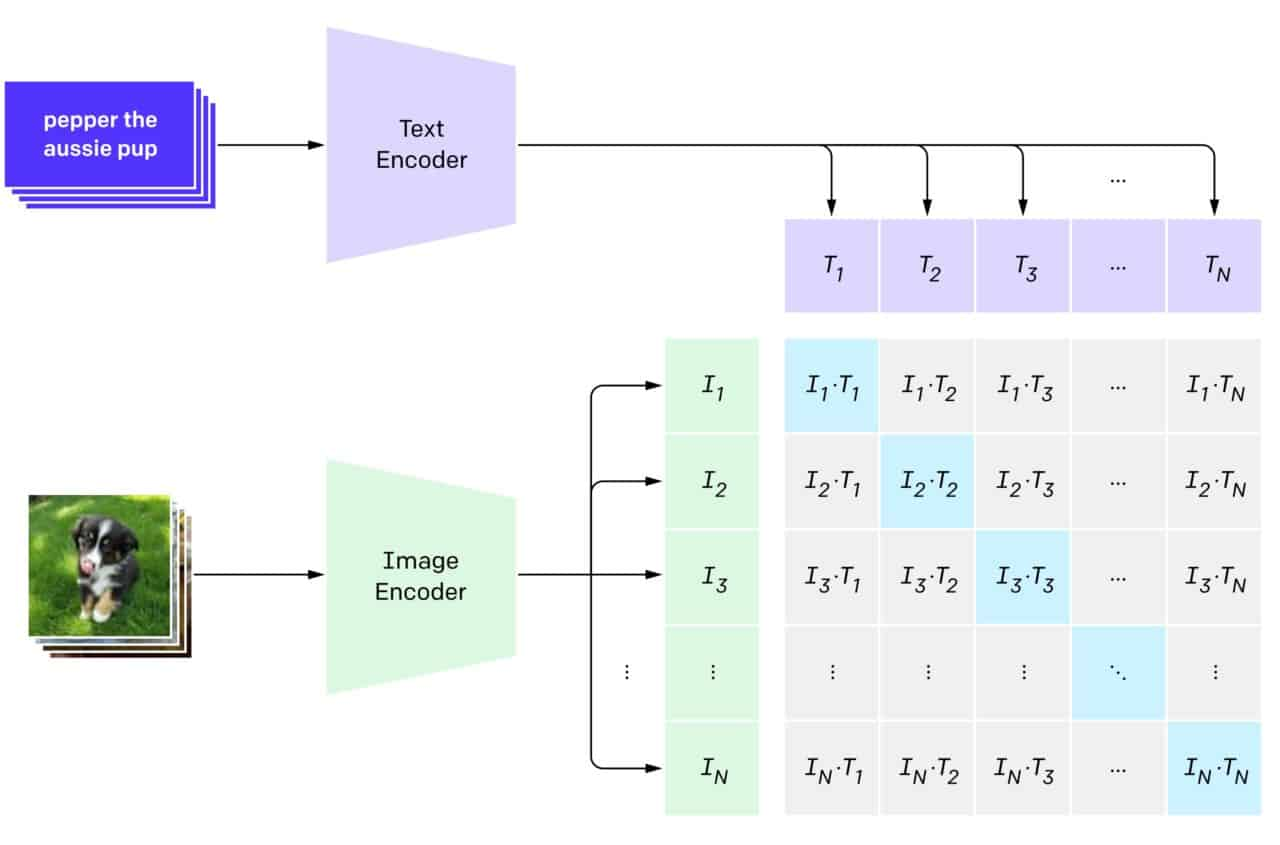

In [76]:
# ===============================
# CLIP (учебная версия) + CIFAR10
# ===============================
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T


# -------------------------
# 1. Простой char-токенизатор
# -------------------------
class CharTokenizer:
    """
    Минимальный токенизатор по символам.
    Добавляем служебные токены: [PAD], [UNK], [CLS].
    """
    def __init__(self, texts, extra_tokens=("[PAD]", "[UNK]", "[CLS]")):
        chars = set()
        for t in texts:
            chars.update(list(t))
        self.pad_token, self.unk_token, self.cls_token = extra_tokens
        self.chars = [self.pad_token, self.unk_token, self.cls_token] + sorted(chars)
        self.stoi = {ch: i for i, ch in enumerate(self.chars)}
        self.itos = {i: ch for ch, i in self.stoi.items()}
        self.pad_id = self.stoi[self.pad_token]
        self.unk_id = self.stoi[self.unk_token]
        self.cls_id = self.stoi[self.cls_token]

    def encode(self, text, add_cls=True):
        toks = [self.cls_id] if add_cls else []
        for ch in text:
            toks.append(self.stoi.get(ch, self.unk_id))
        return toks

    def encode_batch(self, texts, max_len=None, add_cls=True):
        encoded = [self.encode(t, add_cls=add_cls) for t in texts]
        if max_len is None:
            max_len = max(len(e) for e in encoded)
        padded = []
        for e in encoded:
            if len(e) < max_len:
                e = e + [self.pad_id] * (max_len - len(e))
            else:
                e = e[:max_len]
            padded.append(e)
        return torch.tensor(padded, dtype=torch.long)

    def vocab_size(self):
        return len(self.chars)


# -------------------------------------
# 2. Мини-трансформерный блок для текста
# -------------------------------------
class MiniTransformerBlock(nn.Module):
    def __init__(self, dim, num_heads=2, mlp_ratio=4.0, dropout=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads,
                                          dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        hidden = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, dim),
            nn.Dropout(dropout),
        )

    def forward(self, x, key_padding_mask=None):
        # x: (B,T,D)
        x_res = x
        x_norm = self.norm1(x)
        attn_out, _ = self.attn(
            x_norm, x_norm, x_norm,
            key_padding_mask=key_padding_mask  # bool mask: True=игнорировать
        )
        x = x_res + attn_out

        x_res = x
        x_norm = self.norm2(x)
        x = x_res + self.mlp(x_norm)
        return x


# ----------------------------
# 3. Текстовый энкодер CLIP-lite
# ----------------------------
class SimpleTextEncoder(nn.Module):
    """
    Вход: токены (B,T)
    - Embedding
    - Позиционные эмбеддинги
    - 1 TransformerBlock
    - Pool CLS (первый токен)
    - Проекция в embed_dim
    - L2-нормализация в CLIP модели, не здесь
    """
    def __init__(
        self,
        vocab_size,
        ctx_len,
        text_width=128,   # внутренняя ширина
        embed_dim=64,     # выход (CLIP пространство)
        pad_id=0,
        dropout=0.0,
    ):
        super().__init__()
        self.pad_id = pad_id
        self.ctx_len = ctx_len
        self.text_width = text_width

        self.token_emb = nn.Embedding(vocab_size, text_width)
        self.pos_emb = nn.Embedding(ctx_len, text_width)

        self.block = MiniTransformerBlock(text_width, num_heads=4, dropout=dropout)
        self.final_norm = nn.LayerNorm(text_width)
        self.proj = nn.Linear(text_width, embed_dim)

        nn.init.trunc_normal_(self.token_emb.weight, std=0.02)
        nn.init.trunc_normal_(self.pos_emb.weight, std=0.02)
        nn.init.trunc_normal_(self.proj.weight, std=0.02)
        if self.proj.bias is not None:
            nn.init.zeros_(self.proj.bias,)

    def forward(self, token_ids):
        """
        token_ids: (B,T)
        """
        B, T = token_ids.shape
        device = token_ids.device

        tok = self.token_emb(token_ids)  # (B,T,Dw)

        pos_idx = torch.arange(T, device=device).unsqueeze(0).expand(B, T)
        pos = self.pos_emb(pos_idx)

        x = tok + pos  # (B,T,Dw)

        key_padding_mask = (token_ids == self.pad_id)  # True=игнорировать
        x = self.block(x, key_padding_mask=key_padding_mask)

        x = self.final_norm(x)

        # предполагаем, что токен 0 = CLS (мы добавили его в CharTokenizer)
        cls_vec = x[:, 0, :]         # (B,Dw)

        emb = self.proj(cls_vec)     # (B,embed_dim)
        return emb                   # нормализуем позже в CLIP


# ----------------------------
# 4. Визуальный энкодер CLIP-lite
# ----------------------------
class SimpleImageEncoder(nn.Module):
    """
    CIFAR10: 32x32. Используем patch_size=4 → 8x8=64 патчей.
    Conv2d как патч-проекция.
    Позиционные эмбеддинги + среднее по патчам → проекция в embed_dim.
    """
    def __init__(
        self,
        img_size=32,
        patch_size=4,
        in_chans=3,
        vision_width=128,
        embed_dim=64,
    ):
        super().__init__()
        assert img_size % patch_size == 0
        self.img_size = img_size
        self.patch_size = patch_size
        self.vision_width = vision_width

        self.patch_proj = nn.Conv2d(in_chans, vision_width,
                                    kernel_size=patch_size,
                                    stride=patch_size)
        num_patches = (img_size // patch_size) ** 2

        self.pos_emb = nn.Parameter(torch.zeros(1, num_patches, vision_width))
        nn.init.trunc_normal_(self.pos_emb, std=0.02)

        # можно вставить трансформерные блоки; для простоты Identity
        self.transform = nn.Identity()

        self.proj = nn.Linear(vision_width, embed_dim)
        nn.init.trunc_normal_(self.proj.weight, std=0.02)
        if self.proj.bias is not None:
            nn.init.zeros_(self.proj.bias)

    def forward(self, images):
        """
        images: (B,C,H,W) с H=W=img_size
        return: (B,embed_dim)
        """
        B, C, H, W = images.shape
        assert H == self.img_size and W == self.img_size, "Подай изображение нужного размера."

        x = self.patch_proj(images)         # (B,Dv,H',W') где H'=W'=img_size//patch_size
        x = x.flatten(2).transpose(1, 2)    # (B,N,Dv)

        x = x + self.pos_emb[:, :x.size(1), :]
        x = self.transform(x)               # (B,N,Dv)

        pooled = x.mean(dim=1)              # (B,Dv) mean-пулинг патчей

        emb = self.proj(pooled)             # (B,embed_dim)
        return emb


# ----------------------------
# 5. Косинусная матрица и CLIP-лосс
# ----------------------------
def cosine_sim_matrix(image_embeds, text_embeds):
    """
    image_embeds: (Bi,D)
    text_embeds:  (Bt,D)
    return: (Bi,Bt)
    """
    image_embeds = F.normalize(image_embeds, dim=-1)
    text_embeds  = F.normalize(text_embeds,  dim=-1)
    return image_embeds @ text_embeds.T


def clip_loss_from_logits(logits_per_image, logits_per_text):
    """
    logits_*: (B,B)
    цели: правильные пары по диагонали
    """
    n = logits_per_image.size(0)
    target = torch.arange(n, device=logits_per_image.device)
    loss_i = F.cross_entropy(logits_per_image, target)
    loss_t = F.cross_entropy(logits_per_text, target)
    return 0.5 * (loss_i + loss_t)


# ----------------------------
# 6. CLIP модель
# ----------------------------
class SimpleCLIP(nn.Module):
    def __init__(self, image_encoder, text_encoder, init_temperature=0.07):
        super().__init__()
        self.image_encoder = image_encoder
        self.text_encoder = text_encoder
        # храним log(1/τ)
        self.logit_scale = nn.Parameter(torch.log(torch.tensor(1.0 / init_temperature)))

    def forward(self, images, token_ids):
        img_emb = self.image_encoder(images)  # (B,D)
        txt_emb = self.text_encoder(token_ids)  # (B,D)

        img_emb = F.normalize(img_emb, dim=-1)
        txt_emb = F.normalize(txt_emb, dim=-1)

        scale = self.logit_scale.exp().clamp(max=100.0)

        logits_per_image = img_emb @ txt_emb.T * scale
        logits_per_text  = logits_per_image.T
        return logits_per_image, logits_per_text


# ----------------------------
# 7. CIFAR10 загрузка
# ----------------------------
def build_cifar10_dataloaders(batch_size=128, num_workers=2, root="./data"):
    # CIFAR10 статистики (стандартные)
    mean = (0.4914, 0.4822, 0.4465)
    std  = (0.2023, 0.1994, 0.2010)
    transform_train = T.Compose([
        T.RandomHorizontalFlip(),
        T.RandomCrop(32, padding=4),
        T.ToTensor(),
        T.Normalize(mean, std),
    ])
    transform_test = T.Compose([
        T.ToTensor(),
        T.Normalize(mean, std),
    ])

    trainset = torchvision.datasets.CIFAR10(root=root, train=True, download=True, transform=transform_train)
    testset  = torchvision.datasets.CIFAR10(root=root, train=False, download=True, transform=transform_test)

    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True,  num_workers=num_workers, pin_memory=True)
    testloader  = DataLoader(testset,  batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    return trainset, testset, trainloader, testloader


# ----------------------------
# 8. Подготовка текстовых подпечатей для классов CIFAR10
# ----------------------------
def build_class_prompts_cifar10(class_names):
    # простые шаблоны; можно усложнить ("a photo of a small {cls} animal", etc.)
    return [f"a photo of a {name}" for name in class_names]


# ----------------------------
# 9. Обёртка: подготовка токенов для классов
# ----------------------------
def prepare_text_stuff(class_prompts, max_len=32):
    tokenizer = CharTokenizer(class_prompts)
    class_token_ids = tokenizer.encode_batch(class_prompts, max_len=max_len, add_cls=True)  # (num_classes, max_len)
    return tokenizer, class_token_ids


# ----------------------------
# 10. Тренинг CLIP на CIFAR10
# ----------------------------
def train_clip_on_cifar10(
    epochs=5,
    batch_size=128,
    lr=1e-3,
    device="cuda" if torch.cuda.is_available() else "cpu",
):
    # --- данные ---
    trainset, testset, trainloader, testloader = build_cifar10_dataloaders(batch_size=batch_size)

    class_prompts = build_class_prompts_cifar10(trainset.classes)
    tokenizer, class_token_ids = prepare_text_stuff(class_prompts, max_len=32)

    vocab_size = tokenizer.vocab_size()
    pad_id = tokenizer.pad_id

    # --- модели энкодеров ---
    txt_enc = SimpleTextEncoder(
        vocab_size=vocab_size,
        ctx_len=class_token_ids.size(1),
        text_width=128,
        embed_dim=64,
        pad_id=pad_id,
    )

    img_enc = SimpleImageEncoder(
        img_size=32, patch_size=4,
        in_chans=3,
        vision_width=128,
        embed_dim=64,
    )

    model = SimpleCLIP(img_enc, txt_enc).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

    class_token_ids = class_token_ids.to(device)  # (10, ctx_len)

    # --- обучение ---
    model.train()
    for epoch in range(1, epochs + 1):
        running_loss = 0.0
        for images, labels in trainloader:
            images = images.to(device)                # (B,3,32,32)
            labels = labels.to(device)                # (B,)
            # подбираем текст под label: берем соответствующую строку из class_token_ids
            batch_tokens = class_token_ids[labels]    # (B, ctx_len)

            logits_i, logits_t = model(images, batch_tokens)
            loss = clip_loss_from_logits(logits_i, logits_t)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(trainloader.dataset)
        print(f"Epoch {epoch}/{epochs} - train loss: {epoch_loss:.4f}")

        # простая проверка zero-shot после каждой эпохи
        eval_acc = evaluate_zero_shot_cifar10(model, testloader, class_token_ids, device)
        print(f"  Zero-shot top-1 acc: {eval_acc*100:.2f}%")

    return model, tokenizer, class_token_ids


# ----------------------------
# 11. Zero-shot классификация CIFAR10 через CLIP сходство
# ----------------------------
@torch.no_grad()
def evaluate_zero_shot_cifar10(model, testloader, class_token_ids, device):
    model.eval()
    correct = 0
    total = 0

    # предвычислим текстовые эмбеддинги классов 1 раз
    text_embs = model.text_encoder(class_token_ids.to(device))   # (10,D)
    text_embs = F.normalize(text_embs, dim=-1)

    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)

        img_embs = model.image_encoder(images)    # (B,D)
        img_embs = F.normalize(img_embs, dim=-1)

        # (B,10)
        sims = img_embs @ text_embs.T * model.logit_scale.exp().clamp(max=100.0)

        preds = sims.argmax(dim=-1)               # (B,)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    model.train()
    return acc


# ----------------------------
# 12. Быстрый прогон (закомментируй если не надо сразу тренить)
# ----------------------------
model, tokenizer, class_token_ids = train_clip_on_cifar10(
     epochs=5,
     batch_size=128,
     lr=1e-3,
 )


Epoch 1/5 - train loss: 4.6806
  Zero-shot top-1 acc: 23.33%
Epoch 2/5 - train loss: 4.6125
  Zero-shot top-1 acc: 23.20%
Epoch 3/5 - train loss: 4.6108
  Zero-shot top-1 acc: 23.48%
Epoch 4/5 - train loss: 4.6093
  Zero-shot top-1 acc: 23.20%
Epoch 5/5 - train loss: 4.6085
  Zero-shot top-1 acc: 22.99%


In [78]:
from PIL import Image
import torchvision.transforms as T
device = 'cpu'
# Предобр для CIFAR10-совместимого размера
prep = T.Compose([
    T.Resize((32,32)),
    T.ToTensor(),
    T.Normalize((0.4914,0.4822,0.4465),(0.2023,0.1994,0.2010))
])

img = Image.open("/content/Dog_Breeds.jpg").convert("RGB")
img_t = prep(img).unsqueeze(0).to(device)  # (1,3,32,32)

text = "dog"
tok = tokenizer.encode_batch([text], max_len=class_token_ids.size(1), add_cls=True).to(device)  # (1,T)

model.eval()
with torch.no_grad():
    logits_i, logits_t = model(img_t, tok)
    # сходство изображения к тексту
    print("similarity img->txt:", logits_i.item())


similarity img->txt: 1.1171232461929321
